In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import itertools

In [2]:
df = pd.read_csv(r'../data/dataframes/sp_labeled.csv')

#### Cleaning the labeled dataset

In [3]:
# Summary DataFrame with NA counts, non-NA counts, and data types
summary_df = pd.DataFrame({
    'Non-NA Count': df.notna().sum(),
    'NA Count': df.isna().sum(),
    'Data Type': df.dtypes
})

# Display summary DataFrame
summary_df

,Non-NA Count,NA Count,Data Type
SongID,554,0,int64
TrackName,554,0,object
Artists,554,0,object
Genre,482,72,object
FilePath,554,0,object
sp_danceability,529,25,float64
sp_energy,529,25,float64
sp_key,529,25,float64
sp_loudness,529,25,float64
sp_speechiness,529,25,float64


Get rid of rows with no chorus start/stop time.
Rows with no first chorus start times meant they were skipped during the labeling process

In [4]:
df = df.dropna(subset=['chorus_start_1'])
df = df.loc[df['chorus_start_1'].str.strip().astype(bool)]
df = df.reset_index(drop=True)

Convert label time format into seconds with 1 decimal

In [5]:
# Function to convert label columns from hh:mm:ss.f to seconds with one decimal
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return None  # Keep NA values as they are
    try:
        # Split the string and convert to timedelta
        h, m, s = time_str.split(':')
        sec = int(h) * 3600 + int(m) * 60 + float(s)
        return '{:.1f}'.format(sec)  # Format with one decimal point
    except Exception as e:
        print(f"Error converting time: {e}")
        return None
        
time_columns = ['chorus_start_1', 'chorus_start_2', 'chorus_start_3',
                'chorus_end_1', 'chorus_end_2', 'chorus_end_3']

for col in time_columns:
    # Convert to datetime, if not already in a proper time format
    df[col] = df[col].apply(convert_to_seconds)

In [6]:
# Summary DataFrame with NA counts, non-NA counts, and data types
summary_df = pd.DataFrame({
    'Non-NA Count': df.notna().sum(),
    'NA Count': df.isna().sum(),
    'Data Type': df.dtypes
})

# Display summary DataFrame
summary_df

,Non-NA Count,NA Count,Data Type
SongID,332,0,int64
TrackName,332,0,object
Artists,332,0,object
Genre,294,38,object
FilePath,332,0,object
sp_danceability,320,12,float64
sp_energy,320,12,float64
sp_key,320,12,float64
sp_loudness,320,12,float64
sp_speechiness,320,12,float64


Parsing out the sp_genre columns because it contains multiple genres that Spotify associates with the artist of a track (SongID).

In [7]:
# Convert the comma-separated string of genres to a list of genres
df['sp_genre'] = df['sp_genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

In [40]:
# Initialize a list to store rows of the tidy DataFrame
tidy_rows = []

# Determine maximum number of chorus labels available
max_chorus_labels = 3

# Reshape data
for i, row in df.iterrows():
    song_id = row['SongID']
    for j in range(1, max_chorus_labels + 1):
        start_time = row[f'chorus_start_{j}']
        end_time = row[f'chorus_end_{j}']
        if pd.notnull(start_time) and pd.notnull(end_time):
            # Append valid chorus segment to list
            tidy_rows.append({'SongID': song_id, 'start_time': start_time, 'end_time': end_time, 'label': 'chorus'})

# Create tidy DataFrame from the list of rows
tidy_df = pd.DataFrame(tidy_rows)

# Print tidy DataFrame
print(tidy_df)

     SongID start_time end_time   label
0         1       61.0    121.9  chorus
1         1      167.7    228.6  chorus
2         2       92.2    138.3  chorus
3         2      184.3    230.4  chorus
4         3       47.6     91.4  chorus
..      ...        ...      ...     ...
739     551      119.0    149.8  chorus
740     552       53.4     83.9  chorus
741     552      144.9    175.4  chorus
742     553       30.7     76.4  chorus
743     553      129.8    190.7  chorus

[744 rows x 4 columns]


#### Visualizing the genres in the dataset

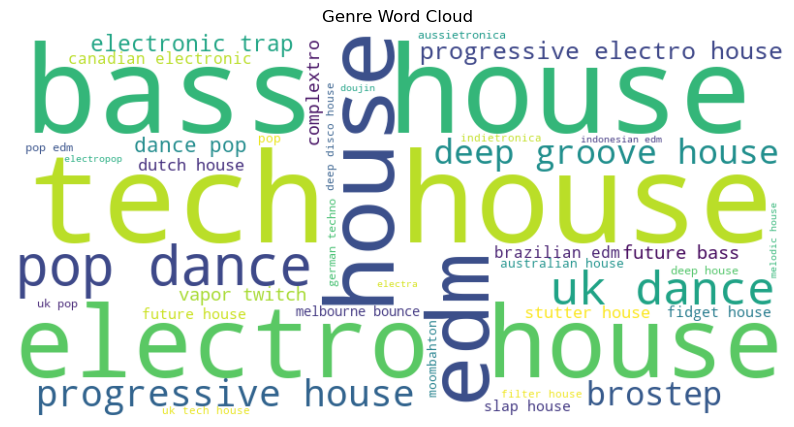

In [8]:
# Flatten the list of genres
all_genres = [genre for sublist in df['sp_genre'] if isinstance(sublist, list) for genre in sublist]

# Count the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Filter out genres with less than 5 occurrences
popular_genres = genre_counts[genre_counts >= 5]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(popular_genres)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre Word Cloud')
plt.show()

In [9]:
# Create a dictionary to store the number of unique artists associated with each genre
genre_artist_counts = {}

# Iterate over the unique genres in genre_counts
for genre in genre_counts.index:
    # Initialize an empty set to store unique artists for each genre
    unique_artists = set()
    # Iterate over rows where the genre appears in sp_genre
    for idx, row in df[df['sp_genre'].apply(lambda x: genre in x)].iterrows():
        # Split artists by '/' and add to the set
        artists = row['Artists'].split('/')
        unique_artists.update(artists)
    # Store the number of unique artists for the genre
    genre_artist_counts[genre] = len(unique_artists)

# Sort the dictionary by the number of unique artists in descending order
sorted_genre_artist_counts = dict(sorted(genre_artist_counts.items(), key=lambda item: item[1], reverse=True))

# Print the number of unique artists associated with each genre
print("Number of unique artists associated with each genre (from greatest to least):")
for genre, count in sorted_genre_artist_counts.items():
    print(f"{genre}: {count}")

Number of unique artists associated with each genre (from greatest to least):
tech house: 109
electro house: 104
house: 104
edm: 95
bass house: 85
pop dance: 79
uk dance: 56
progressive house: 46
progressive electro house: 40
brostep: 38
deep groove house: 32
dutch house: 28
electronic trap: 27
dance pop: 25
canadian electronic: 21
fidget house: 17
deep house: 17
complextro: 16
slap house: 16
pop rap: 16
stutter house: 15
uk pop: 15
vapor twitch: 14
moombahton: 14
deep disco house: 14
filter house: 13
rap: 13
pop: 12
indietronica: 12
electropop: 12
future bass: 11
brazilian edm: 11
pop edm: 11
aussietronica: 11
melodic house: 11
sky room: 11
future house: 10
australian house: 10
german techno: 10
classic soul: 10
soul: 10
gangster rap: 10
hip hop: 10
melbourne bounce: 9
uk tech house: 9
italian tech house: 9
nu disco: 9
electra: 8
indie poptimism: 8
funk: 8
trap: 8
southern hip hop: 8
covertronica: 8
dubstep: 7
indie soul: 7
uk house: 7
experimental bass: 7
disco house: 6
minimal techn

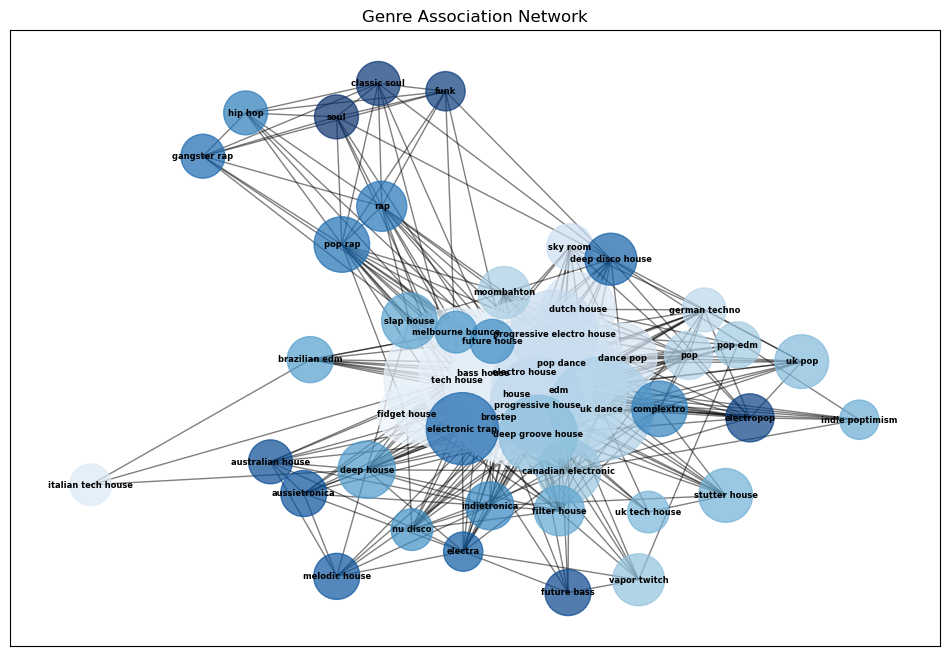

In [10]:
# Create an empty graph
G = nx.Graph()

# Get the top 50 genres based on the number of unique artists associated with each genre
top_genres = list(sorted_genre_artist_counts.keys())[:50]

# Create a dictionary to store the number of unique artists associated with each genre
genre_artist_counts = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    genres = row['sp_genre']
    artists = row['Artists'].split('/')
    for genre in genres:
        if genre in top_genres:
            genre_artist_counts.setdefault(genre, set()).update(artists)

# Add nodes and edges to the graph
for genre, artists in genre_artist_counts.items():
    G.add_node(genre, size=len(artists))

for genres in df['sp_genre']:
    for genre1 in genres:
        if genre1 in top_genres:
            for genre2 in genres:
                if genre2 in top_genres and genre1 != genre2:
                    if G.has_edge(genre1, genre2):
                        G[genre1][genre2]['weight'] += 1
                    else:
                        G.add_edge(genre1, genre2, weight=1)

# Get the node sizes
node_sizes = [G.nodes[n]['size'] * 100 for n in G.nodes]

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)  # Layout algorithm

# Draw edges with thickness based on edge weights
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw nodes with sizes based on number of unique artists associated and customize appearance
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=range(len(G)), cmap=plt.cm.Blues, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold')  # Adjust font_size to 6 for smaller text

plt.title('Genre Association Network')
plt.show()

In [15]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from typing import Tuple, Optional

In [13]:
# Load the audio file
audio_file = r"..\data\audio_files\processed\2.mp3"
hop_length = 512
sr=22050

y, sr = librosa.load(audio_file, sr=22050) 
duration = librosa.get_duration(y=y, sr=sr, hop_length=hop_length)
y_harm, y_perc = librosa.effects.hpss(y)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)

In [32]:
def get_studio_bpm(beat_frames: np.ndarray, sr: int = 22050, hop_length: int = 512,
                   variance_threshold: float = 0.01, window_length: int = 4) -> Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
    """
    Analyze the provided beat frame indices to determine the studio BPM and the start frame of stable intervals.
    
    Parameters:
    - beat_frames (np.ndarray): Array of beat frame indices generated from librosa.
    - sr (int): The sample rate of the audio. Default is 22050 Hz.
    - hop_length (int): The number of samples per frame. Default is 512.
    - variance_threshold (float): The threshold for the variance to consider a window of beats as stable.
    - window_length (int): The number of beats to consider within each sliding window when calculating variance.

    Returns:
    Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
        - The mean studio BPM (float or None if not determined).
        - The median studio BPM (float or None if determined).
        - The BPM that occurs most frequently near a whole number (float or None if not determined).
        - The frame indices of the first beat of each stable interval.
        - An array of beat interval durations that are considered stable.
    """
    
    # Calculate the time in seconds for each beat frame index
    beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length)

    # Calculate beat intervals
    beat_intervals = np.diff(beat_times)
    total_intervals = len(beat_intervals)

    # Store stable intervals (low-variance windows)
    stable_intervals = []
    stable_frames = []

    # Calculate variance in a sliding window
    for i in range(total_intervals - window_length + 1):
        window = beat_intervals[i:i + window_length]
        if np.var(window) < variance_threshold:
            # Extend the list with intervals from the current stable window
            stable_intervals.extend(window)
            # Record the frame index of the first beat in the stable window
            stable_frames.append(beat_frames[i])


    # If we found any stable intervals, calculate the BPMs
    if stable_intervals:
        # Calculate BPMs for each stable interval
        stable_bpms = 60.0 / np.array(stable_intervals)
        mean_studio_bpm = np.mean(stable_bpms)
        median_studio_bpm = np.median(stable_bpms)
    
        # Find the BPM closest to a whole number
        differences = np.abs(stable_bpms - np.round(stable_bpms))
        index_of_closest_bpm = np.argmin(differences)
        closest_whole_bpm = stable_bpms[index_of_closest_bpm]
    else:
        # No stable intervals found; return None for mean and median BPM
        mean_studio_bpm = None
        median_studio_bpm = None
        closest_whole_bpm = None

    # Return the mean and median studio BPM if calculated, the mode BPM, the frame indices of the stable beats, and the stable interval durations
    return mean_studio_bpm, stable_frames


def quantize_beats(stable_frames: np.ndarray, studio_bpm: float, duration: float, sr: int = 22050, hop_length: int = 512):
    """
    Creates a measure grid based on the studio BPM and the starting time of the first stable interval, 
    extrapolating the grid to the start and end of the song.

    Parameters:
    stable_frames : np.ndarray
        An array of starting frames for stable beat interval sequences.
    studio_bpm : float
        Estimated studio BPM of the audio in beats per minute.
    sr : int
        Sampling rate of the audio signal.
    hop_length : int
        Hop length used in the onset detection and beat tracking.
    duration : float
        Duration of the audio signal in seconds.

    Returns:
    measure_grid : np.ndarray
        Array of quantized measure start times based on the studio BPM.
    measure_length : float
        Length of a measure in seconds based on the studio BPM.
    """ 
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4

    # Calculate beat interval in seconds using the studio BPM
    beat_interval = 60.0 / studio_bpm

    # Convert the frame index of the first stable interval to time
    first_stable_beat_time = librosa.frames_to_time(stable_frames[0], sr=sr, hop_length=hop_length)

    # Calculate the number of full measures from the start to first stable beat
    measures_to_first_stable = int(np.floor(first_stable_beat_time / (beat_interval * beats_per_measure)))

    # Calculate the start time of the first measure by subtracting the time of complete measures
    first_measure_time = first_stable_beat_time - (measures_to_first_stable * beat_interval * beats_per_measure)

    # Create the beat grid starting from the first measure time, going backwards to the beginning of the song
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    
    # Create the beat grid starting from the first measure time, going forwards to the end of the song
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)

    # Combine both grids and sort them to create a continuous beat grid
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))

    # Filter out any negative times that may have resulted from the backward extrapolation
    beat_grid = beat_grid[beat_grid >= 0]

    # Ensure beat grid does not go past the duration of the song
    beat_grid = beat_grid[beat_grid <= duration]

    # Create measure grid by selecting every fourth beat (assuming 4/4 time)
    measure_grid = beat_grid[::beats_per_measure]

    # Calculate the length of a measure
    measure_length = beat_interval * beats_per_measure

    return measure_grid, measure_length


def apply_measure_grid(ax, measure_grid):
    """
    This function takes an axis object and applies measure grid lines,
    sets x-ticks to measure start times for every fourth measure starting from measure 0,
    labels them with measure numbers, and applies sub-ticks for intermediate measure times.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis object to modify.
    measure_grid (list or array): The list or array of measure start times in seconds.
    """
    measure_numbers = np.arange(len(measure_grid))
    # Adjust the list to start from measure 0 and get every fourth measure
    major_measure_indices = [i for i, measure_num in enumerate(measure_numbers) if (measure_num) % 4 == 0]
    major_measures = [measure_grid[i] for i in major_measure_indices]
    major_labels = [measure_numbers[i] for i in major_measure_indices]
    
    # Set major x-axis ticks and labels (for measure 0 and every fourth measure after)
    ax.set_xticks(major_measures, minor=False)
    ax.set_xticklabels(major_labels, minor=False)

    # Set minor x-axis ticks (for intermediate measures)
    minor_measures = [measure for i, measure in enumerate(measure_grid) if i not in major_measure_indices]
    ax.set_xticks(minor_measures, minor=True)
    
    # Overlay the major measure grid lines on the plot (for measure 0 and every fourth measure after)
    for measure_time in major_measures:
        ax.axvline(x=measure_time, color='green', linestyle='--', linewidth=2)  # Adjusted linewidth for major ticks
    
    # Overlay the minor measure grid lines on the plot (for intermediate measures)
    for measure_time in minor_measures:
        ax.axvline(x=measure_time, color='grey', linestyle=':', linewidth=1, alpha=0.8)  # Adjusted linewidth for minor ticks
    
    ax.set_xlabel('Measure Number')

In [33]:
studio_bpm, stable_frames = get_studio_bpm(beats)
measure_grid, measure_length = quantize_beats(stable_frames, studio_bpm, duration)

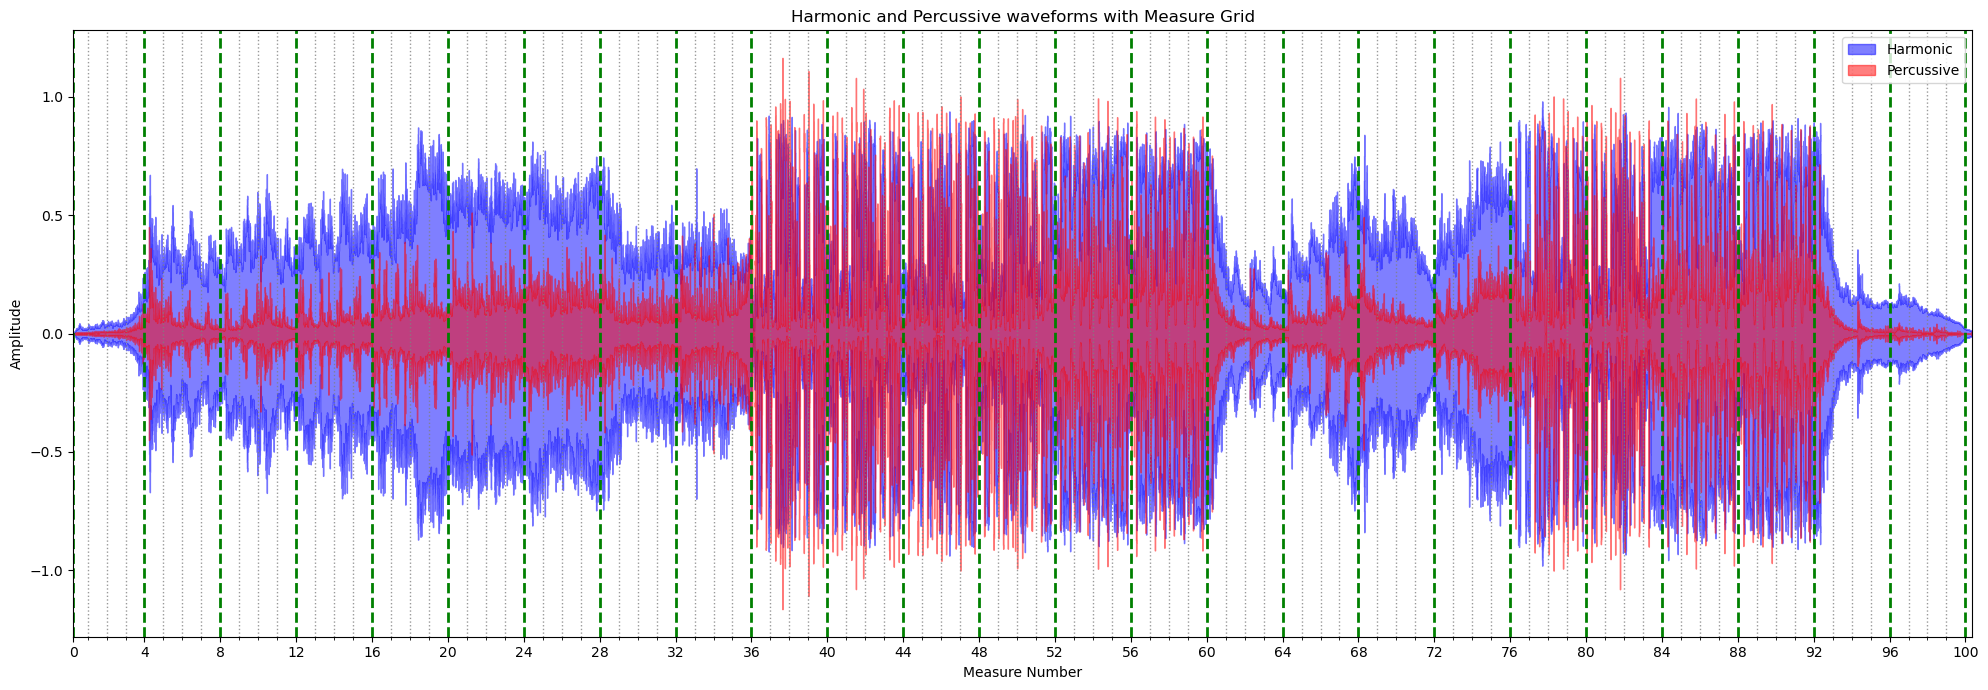

In [31]:
fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax, label='Harmonic', color='b')
librosa.display.waveshow(y_perc, sr=sr, alpha=0.5, ax=ax, label='Percussive', color='r')
ax.set_xlim([0, duration])
apply_measure_grid(ax, measure_grid)
ax.set_ylabel('Amplitude')
ax.set(title='Harmonic and Percussive waveforms with Measure Grid')
ax.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'MelSpectrogram')

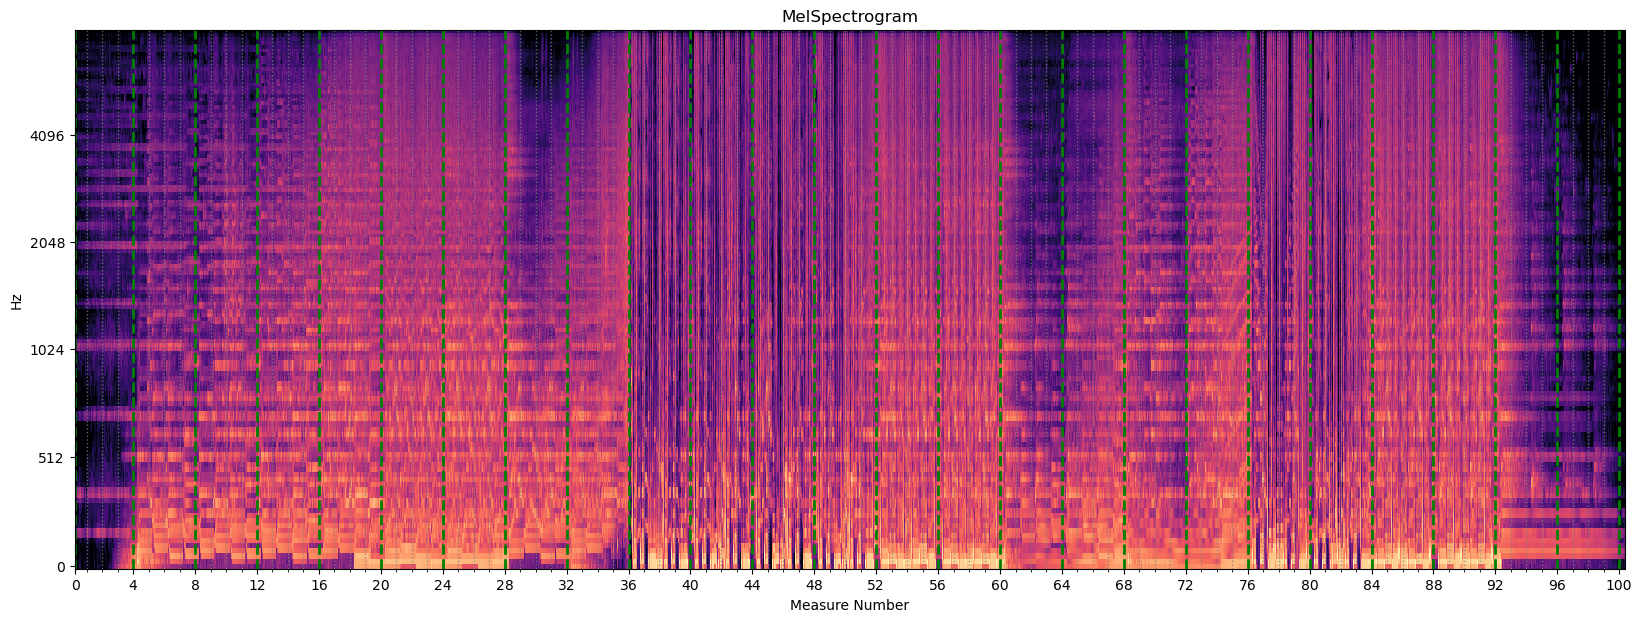

In [36]:
# Compute Melspectrogram
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
apply_measure_grid(ax, measure_grid)
ax.set_title('MelSpectrogram')

In [42]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Constants
audio_file = r"..\data\audio_files\processed\2.mp3"
hop_length = 512
sr = 22050
segment_length = measure_length
num_classes = 1

# Load the audio file and compute Mel spectrogram
y, sr = librosa.load(audio_file, sr=sr)
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Preprocessing: Reshape and split data
# Reshape the spectrogram to match the input shape expected by the CNN
S_dB = S_dB.reshape((1, S_dB.shape[0], S_dB.shape[1], 1))

# Define CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=S_dB.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Adjust activation based on the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Adjust loss based on the task
              metrics=['accuracy'])

# Train the model
model.fit(S_dB, labels, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)  # Adjust validation_split as needed

NameError: name 'labels' is not defined

In [44]:
tidy_df.loc[tidy_df["SongID"]== 2]

,SongID,start_time,end_time,label
2,2,92.2,138.3,chorus
3,2,184.3,230.4,chorus
